# What Is the Relationship between Housing Characteristics and Complaints?

The goal of this exercise is to find the answer to the Question 3 of the problem statement: 

> Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

In this exercise, we shall use the 311 dataset in combination with the PLUTO data set. The latter shall be used for the most problematic borough that was identified as a part of answering the Question 2. 
Remember that, the answer to Question 1 (What Is the Top Complaint Type?) was: 

> The most often reported complaint is 'HEAT/HOT WATER'

The answe to Question 2 (What Areas Should the Agency Focus On?) was:

> The borough with the most 'HEAT/HOT WATER' complaints is 'BRONX'

Therefore, in the remainder we shall analyze whether the 'HEAT/HOT WATER' comlaints reported in 'BRONX' have obvious relationship with any particular house characteristics.

# The data sets
The 311 dataset is already well known to us as it was used to answer Questions 1 & 2, therefore it does not require any special introduction. 

The PLUTO data set is new to us and it aggregates condominium unit tax lot informationto the billing lot.
The initially recommended (by the course advisers) PLUTO data set fields to consider are:

|    Field   |                  Description                     |
|------------|--------------------------------------------------|
| Address    | An address of the tax lot |
| BldgArea   | The total gross area in square feet |
| BldgDepth  | The building’s depth, measured in feet |
| BuiltFAR   | The build floor area ration |
| CommFAR    | The maximum allowable commercial floor area ratio |
| FacilFAR   | The maximum allowable community facility floor area ratio |
| Lot        | The one to four-digit tax lot number |
| LotArea    | Total area of the tax lot, in square feet |
| LotDepth   | The tax lot's depth measured in feet |
| NumBldgs   | The number of buildings on the tax lot |
| NumFloors  | The number of full and partialstories starting from the ground floor, for the tallest building on the tax lot |
| OfficeArea | An estimate of theexterior dimensions of the portion of the structure(s) allocated for office use |
| ResArea    | An estimate of the exterior dimensions of the portion of the structure(s) allocated for residential use |
| ResidFAR   | The maximum allowable residential floor area ratio |
| RetailArea | An estimate of the exterior dimensions of the portion of the structure(s) allocated for retail use |
| YearBuilt  | The year construction of the building was completed |
| YearAlter1 | Is the year of the building's most recent alteration |
| ZipCode    | A ZIP code that is valid for one of the addresses assigned to the tax lot |
| XCoord     | The X coordinate of the XY coordinate pair which depicts the approximate location of the lot |
| YCoord     | The Y coordinate of the XY coordinate pair which depicts the approximate location of the lot |

Consider reading the [PLUTO Data Dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=19v2) for more details. The data set archive consists of several CSV files, each devoted to a single borough:

|   CSV file  |      Borough       |
|-------------|--------------------|
| QN_18v1.csv | QUEENS |
| BK_18v1.csv | BROOKLYN |
| SI_18v1.csv | STATEN ISLAND |
| BX_18v1.csv | BRONX |
| MN_18v1.csv | MANHATTAN |

Since we are interested in borough *'BRONX'* we shall use the data from the corresponding *'BX_18v1.csv'* file.


# Load the data


Loading of the data can be done both from the IBM cloud storage and the locally present CSV files. The latter is decided upon the presence of the proper secure field values of the credentials:

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ibm_boto3

from botocore.client import Config

In [2]:
# @hidden_cell
SECURITY_DUMMY = '----------------'
erm2_nwe9_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'erm2_nwe9.csv'
}
bx_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'BX_18v1.csv'
}

In [3]:
# Allows to get the data source for the credentials from the IBM cloud or local csv file 
def get_data_source(credentials) :
    '''Creates a data source from the IBM cloud or local csv file according to the credentials'''
    # Here we check if the credentials are present, if not try 
    # load the local file if they are then read from the cloud.
    if credentials.get('IAM_SERVICE_ID') == SECURITY_DUMMY :
        # This is the alternative to get the code run locally with a local csv file
        body = 'data' + os.path.sep + credentials.get('FILE')
    else :
        client = ibm_boto3.client(
            service_name = 's3',
            ibm_api_key_id = credentials.get('IBM_API_KEY_ID'),
            ibm_auth_endpoint = credentials.get('IBM_AUTH_ENDPOINT'),
            config = Config(signature_version='oauth'),
            endpoint_url = credentials.get('ENDPOINT'))

        body = client.get_object(
            Bucket = credentials.get('BUCKET'),
            Key = credentials.get('FILE'))['Body']

        # add missing __iter__ method, so pandas accepts body as file-like object
        def __iter__(self): return 0
        if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

    return body

Further, we shall subsequently load the 311 and PLUTO data sets. Along the way, we will select the necessary columns and check on (, and correct if needed,) the column data types.

## The 311 data set
Here we first load the 311 data set:

In [4]:
# Get the data source for the credentials
dhp_ds = get_data_source(erm2_nwe9_creds)

# Read the CSV file
dhp_df = pd.read_csv(dhp_ds, parse_dates = ['created_date', 'closed_date'])

Next we select the data related to the 'HEAT/HOT WATER' comlaints reported in 'BRONX'.

In [5]:
print('Number of all complaints:', dhp_df.shape[0])
dhp_df = dhp_df[(dhp_df['complaint_type'] == 'HEAT/HOT WATER') & (dhp_df['borough'] == 'BRONX')]
print('Number of \'HEAT/HOT WATER\' complaints in \'BRONX\':', dhp_df.shape[0])

Number of all complaints: 6034470
Number of 'HEAT/HOT WATER' complaints in 'BRONX': 609783


Next lest us realize that the 311 data set will only be user to select the lots from the PLUTO data set which had 'HEAT/HOT WATER' complaints in 'BRONX'. Therefore, we shall only keep the relevant columns here, i.e. the property zip code and address. We shall also rename the columns to match those of PLUTO.

In [6]:
dhp_df = dhp_df[['incident_address', 'incident_zip']]
dhp_df = dhp_df.rename({'incident_address':'Address', 'incident_zip':'ZipCode'}, axis=1)
dhp_df.head()

,Address,ZipCode
0,511 EAST 148 STREET,10455.0
7,1275 EDWARD L GRANT HIGHWAY,10452.0
12,152 EAST 171 STREET,10452.0
16,2523 UNIVERSITY AVENUE,10468.0
26,3226 BRONXWOOD AVENUE,10469.0


Finally let us check on the column types:

In [7]:
dhp_df.dtypes

Address     object
ZipCode    float64
dtype: object

The types are in order as the address is a string and the zip code is a float.

## The PLUTO data set
Here we first load the PLUTO data set:

In [8]:
# Get the data source for the credentials
bx_ds = get_data_source(bx_18v1_creds)

# Read the CSV file
bx_df = pd.read_csv(bx_ds, low_memory = False)

Next, we select the recommended fields:

In [9]:
bx_df = bx_df[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR',
              'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth',
              'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
              'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1',
              'ZipCode', 'YCoord', 'XCoord']]

Further list the types of the columns to check if they are all in order:

In [10]:
bx_df.dtypes

Address        object
BldgArea        int64
BldgDepth     float64
BuiltFAR      float64
CommFAR       float64
FacilFAR      float64
Lot             int64
LotArea         int64
LotDepth      float64
NumBldgs        int64
NumFloors     float64
OfficeArea      int64
ResArea         int64
ResidFAR      float64
RetailArea      int64
YearBuilt       int64
YearAlter1      int64
ZipCode       float64
YCoord        float64
XCoord        float64
dtype: object

All the data frame columns have proper numeric types, except for the Address one which is a string.

# Data Exploration and Cleaning
In this section we shall do the initial data exploration of the 311 and PLUTO data sets. As a part of this exploration we will do data cleaning in order to prepare the data sets to subsequent analysis.

## The 311 data set

We can now describe the 311 data set to get some insights in the remaining data:

In [11]:
dhp_df.describe(include='all')

,Address,ZipCode
count,609782,603797.000000
unique,22902,NaN
top,3810 BAILEY AVENUE,NaN
freq,7115,NaN
mean,NaN,10460.695938
std,NaN,6.493728
min,NaN,10451.000000
25%,NaN,10456.000000
50%,NaN,10460.000000
75%,NaN,10467.000000


There is no much to see here as the provided statistics is mostly not informative. For the address, we can only tell that there are `609782` non Na/NaN  ones among which `22902` are unique and that the top complaints address is `3810 BAILEY AVENUE` with `7115` comlaints over all the years. For the zip codes the amount of useful information is even less, we can just use the number of non Na/NaN zip codes: `603797`. The latter indicates that there are about `609782 - 603797 = 5985` Na/NaN zip codes. Thereore, let us now explicitly check for the present Na/NaN values:

In [12]:
missing = dhp_df.isna()
print('The number of missing addresses is:', missing.Address.sum(),
      '\nThe number of missing zip codes is:', missing.ZipCode.sum())

The number of missing addresses is: 1 
The number of missing zip codes is: 5986


As one can see there are missing values which we can not easily restore, so let us drop the corresponding rows:

In [13]:
print('The number of complaints including Na/NaN values:', dhp_df.shape[0])
dhp_df.dropna(inplace = True)
print('The number of clean complaints:', dhp_df.shape[0])

The number of complaints including Na/NaN values: 609783
The number of clean complaints: 603797


As one can see, the amount of dropped data is marginal, i.e. it just about `100 - (603797 * 100 /609783) =  0.98`%.

## The PLUTO data set
We can now describe the PLUTO data set to get some insights in the selected data:

In [14]:
bx_desc = bx_df.describe(include='all')
display(bx_desc)

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord
count,89785,8.985400e+04,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000,8.985400e+04,89854.000000,89854.000000,89854.000000,8.985400e+04,8.985400e+04,89854.000000,89854.000000,89854.000000,89854.000000,89525.000000,86595.000000,8.659500e+04
unique,87017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,SHORE DRIVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.113609e+03,48.229342,1.107134,0.130644,2.853723,111.493601,1.023904e+04,105.978085,1.184778,2.273265,5.057144e+02,5.720876e+03,1.674844,349.916910,1805.695150,176.591782,10464.280726,249975.676667,1.021686e+06
std,NaN,6.520439e+04,31.333564,1.799155,0.574606,1.605805,467.387099,3.058252e+05,73.946506,1.929445,1.492908,1.196641e+04,5.660190e+04,1.309456,4911.023897,499.485278,567.142346,7.292127,9778.614120,8.599340e+03
min,NaN,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,10451.000000,227527.000000,1.002677e+06
25%,NaN,1.598000e+03,35.000000,0.550000,0.000000,2.000000,20.000000,2.188000e+03,95.000000,1.000000,2.000000,0.000000e+00,1.152000e+03,0.900000,0.000000,1920.000000,0.000000,10460.000000,241918.000000,1.014310e+06
50%,NaN,2.226000e+03,44.670000,0.860000,0.000000,2.000000,41.000000,2.508000e+03,100.000000,1.000000,2.000000,0.000000e+00,1.760000e+03,1.100000,0.000000,1931.000000,0.000000,10465.000000,248586.000000,1.023321e+06
75%,NaN,3.288000e+03,55.000000,1.250000,0.000000,4.800000,73.000000,4.250000e+03,102.420000,1.000000,3.000000,0.000000e+00,2.616000e+03,2.430000,0.000000,1960.000000,0.000000,10469.000000,258036.500000,1.027126e+06


If we take a look at the counts row we can see that the numbers varry:
* *'Address'* has `89785`
* *'BldgArea'* to *'YearAlter1'* have `89854`
* *'ZipCode'* has `89525`
* *'YCoord'* and *'XCoord'* have `86595`

In [15]:
bx_df.describe(include='all').loc['count']

Address       89785
BldgArea      89854
BldgDepth     89854
BuiltFAR      89854
CommFAR       89854
FacilFAR      89854
Lot           89854
LotArea       89854
LotDepth      89854
NumBldgs      89854
NumFloors     89854
OfficeArea    89854
ResArea       89854
ResidFAR      89854
RetailArea    89854
YearBuilt     89854
YearAlter1    89854
ZipCode       89525
YCoord        86595
XCoord        86595
Name: count, dtype: object

The total number of rows in the data set is:

In [16]:
print('The number of tax lots:', bx_df.shape[0])

The number of tax lots: 89854


So let us analyze the number of the Na/NaN values, only display columns with positive Na/NaN counts:

In [17]:
missing_counts = bx_df.isna().apply(sum, axis = 0)
display(missing_counts[missing_counts > 0])
print('The total number of Na/NaN values is', np.sum(missing_counts))

Address      69
ZipCode     329
YCoord     3259
XCoord     3259
dtype: int64

The total number of Na/NaN values is 6916


 Assuming the missing values can not be easily restored let us remove the corresponding rows:

In [18]:
bx_df.dropna(inplace = True)
missing_counts = bx_df.isna().apply(sum, axis = 0)
print('The remaining number of rows with Na/NaN values is', np.sum(missing_counts))
print('The remaining number of rows in PLUTO is', bx_df.shape[0])

The remaining number of rows with Na/NaN values is 0
The remaining number of rows in PLUTO is 86591


As one can see, the amount of dropped data is sufficiently small, i.e. it just about `100 - (86591 * 100 /89854) =  3.63`%. Let us now describe the data set again:

In [19]:
bx_df.describe(include='all')

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord
count,86591,8.659100e+04,86591.000000,86591.000000,86591.000000,86591.000000,86591.000000,8.659100e+04,86591.000000,86591.000000,86591.000000,8.659100e+04,8.659100e+04,86591.000000,86591.000000,86591.000000,86591.000000,86591.000000,86591.000000,8.659100e+04
unique,85962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,WEST 246 STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.341031e+03,49.855709,1.143734,0.123250,2.870513,105.260893,9.479385e+03,104.972907,1.224896,2.350154,5.227774e+02,5.891092e+03,1.690055,362.536234,1865.568177,182.272673,10464.266333,249976.088242,1.021686e+06
std,NaN,6.625799e+04,30.325272,1.810324,0.561512,1.597633,426.684680,2.992482e+05,63.283144,1.947582,1.441622,1.218634e+04,5.752111e+04,1.304745,5001.922740,382.054716,575.285484,6.642540,9778.381084,8.598740e+03
min,NaN,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,10451.000000,227527.000000,1.002677e+06
25%,NaN,1.665000e+03,35.000000,0.590000,0.000000,2.000000,20.000000,2.200000e+03,95.000000,1.000000,2.000000,0.000000e+00,1.215000e+03,0.900000,0.000000,1920.000000,0.000000,10460.000000,241918.000000,1.014311e+06
50%,NaN,2.280000e+03,45.000000,0.880000,0.000000,2.000000,41.000000,2.512000e+03,100.000000,1.000000,2.000000,0.000000e+00,1.816000e+03,1.100000,0.000000,1931.000000,0.000000,10465.000000,248586.000000,1.023321e+06
75%,NaN,3.321000e+03,56.000000,1.270000,0.000000,4.800000,72.000000,4.200000e+03,102.070000,1.000000,3.000000,0.000000e+00,2.650000e+03,2.430000,0.000000,1960.000000,0.000000,10469.000000,258037.000000,1.027126e+06


There is now one other thing to notice, namely:

> The 'WEST 246 STREET' Address frequency within the PLUTO data set is indicated to be 23 

If we now list all the addresses with their larger than 1 frequencies, we get:

In [20]:
address_cnts = bx_df.Address.value_counts()
address_cnts[address_cnts > 1]

WEST 246 STREET        23
SHORE DRIVE            20
595 WEST 239 STREET    13
SEDGWICK AVENUE        12
WEBSTER AVENUE         11
                       ..
EAST 169 STREET         2
4045 WILDER AVENUE      2
PELHAM BAY PARK         2
EAST 158 STREET         2
DALY AVENUE             2
Name: Address, Length: 277, dtype: int64

Which consists of 227 addresses and some of them, e.g. the 'SHORE DRIVE' do not have house numbers. This seems confusing as we would expect the address to start with the house number and then to be followed by the street name. Moreover, for the tax lots we would expect to see a single address present in the data set only once.

Let us now read-up on the PLUTO data set description of the *'Address'* column:

> Tax lots may be assigned a single house number on a street, a range of house numbers on a street, or addresses on multiple streets. ADDRESS contains the address in PTS, using the low number when there is a range of house numbers. Some tax lots, such as vacant lots or parks, have only a street name and no house number.

> A complete list of the addresses assigned to a tax lot is available through Geosupport or by downloading the Property Address Directory(PAD) BYTESof the BIGAPPLETM. 

As one can read from the quotes above:

1. The vacant lots and or parks do not have house numbers assigned.
2. The address contains the low number when there is a range of house numbers.
3. The lot can also be assigned to addresses on multiple streets.

These facts may obscure the analysis because:

* Bullet 1 means that if the property was not vakant somewhere between `2014` and `2018` but was vacant by the time the PLUTO data set was created, then the complaints over the proparty that has now become vacant will not be matched with the proper tax lots.
* Bullet 2 means that, without using an additional PAD data set we can not get the complete list of the lot house numbers. This shall result in some 311 complaints not being able to match with a tax lot.
* Bullet 3 means that it is perhaps possible that there are addresses containing lists of house and street numbers. Those whill also not be matchable with the 311 complaints.

We shall adress the issues outlied above in the subsequent section where we shall join the 311 and PLUTO data sets.

For now, let us notice that in the last listing, even some of the complete addresses, e.g. '1023 KELLY STREET', are present multiple times. Below we try to get all of such entries:

In [21]:
# Let us create the pattern for selecting a proper address with one house
# number followed by a white space and then an alpha numeric street name
# which can contain multiple words separated by white spaces
regex_pat = re.compile(r'^\d+(\s+\w+)+')

# Then we match the addresses with the regular expression above
mult_occur = bx_df[bx_df.Address.str.match(regex_pat)]

# We group by such a complete address and count the number of entries
occur_cnt = mult_occur.groupby('Address').size().to_frame()
occur_cnt.reset_index(level=0, inplace = True)
occur_cnt.rename(columns={0:'count'}, inplace = True)

# We add the counts to the table with mulriple occurances, sort 
# by count, and select those adresses that occur at least twice
dupl_result = pd.merge(mult_occur, occur_cnt)
dupl_result.sort_values(by = ['count', 'Address'], axis=0, inplace = True, ascending = False)
dupl_result = dupl_result[dupl_result['count'] > 1]
display(dupl_result.head(5))
print('The total number of street address duplicates is:', dupl_result.shape[0])

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,...,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord,count
84510,595 WEST 239 STREET,0,0.0,0.00,0.0,2.0,110,23750,190.67,0,...,0,0,0.9,0,0,0,10463.0,263487.0,1008989.0,13
84511,595 WEST 239 STREET,1600,40.0,0.48,0.0,2.0,116,3330,91.33,1,...,0,1600,0.9,0,1992,0,10463.0,263428.0,1009218.0,13
84512,595 WEST 239 STREET,1600,40.0,0.85,0.0,2.0,117,1890,76.35,1,...,0,1600,0.9,0,1992,0,10463.0,263418.0,1009188.0,13
84513,595 WEST 239 STREET,1600,40.0,0.85,0.0,2.0,118,1890,70.88,1,...,0,1600,0.9,0,1991,0,10463.0,263424.0,1009167.0,13
84514,595 WEST 239 STREET,1600,40.0,0.85,0.0,2.0,119,1890,76.35,1,...,0,1600,0.9,0,1991,0,10463.0,263426.0,1009146.0,13


The total number of street address duplicates is: 135


As we see there are 135 PLUTO entries that have duplicate street addresses. Let us analyze one of them.

Consider the top occuring '595 WEST 239 STREET' address, let us look at its 'Lot' and 'ZipCode' columns summary:

In [22]:
bx_df.loc[bx_df.Address == '595 WEST 239 STREET', ['Lot','ZipCode']].describe()

,Lot,ZipCode
count,13.000000,13.0
mean,120.615385,10463.0
std,4.699973,0.0
min,110.000000,10463.0
25%,118.000000,10463.0
50%,121.000000,10463.0
75%,124.000000,10463.0
max,127.000000,10463.0


As one can see all the entries have the same zip code `10463.0`. Some of the lot identifiers are different and some are duplicated:

Text(0.5, 1.0, "The frequency of lot identifier values for the '595 WEST 239 STREET' address in PLUTO")

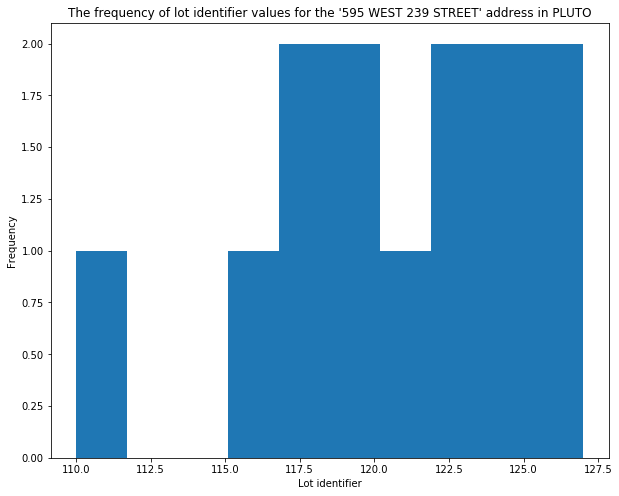

In [23]:
bx_df[bx_df.Address == '595 WEST 239 STREET'].Lot.plot(kind = 'hist', figsize = (10,8))
plt.xlabel('Lot identifier')
plt.title('The frequency of lot identifier values for the \'595 WEST 239 STREET\' address in PLUTO')

It is at the moment hard to judge the reason for the lot duplications and it requires a more thorough investigation. To solve this last problem for now we suggest simply removing all the 'Address' and 'ZipCode' pairs that have duplicate entries in the PLUTO data set.

In [24]:
print('The number of PLUTO entries before removing duplicates: ', bx_df.shape[0])

# First count the distinct ZipCode-Address groups
occur_cnt = bx_df.groupby(['ZipCode','Address']).size().to_frame()
occur_cnt.reset_index(level=0, inplace = True)
occur_cnt.reset_index(level=0, inplace = True)

# Rename the counts column
occur_cnt.rename(columns={0:'Count'}, inplace = True)

# Join the data into the original table
bx_df_tmp = pd.merge(bx_df, occur_cnt, left_on=['ZipCode','Address'], right_on=['ZipCode','Address'])

# Only keep the Address - ZipCode pairs that occur once
rows_index = bx_df_tmp[bx_df_tmp['Count'] > 1].index
bx_df = bx_df_tmp.drop(rows_index, axis = 0)

# Drop the counts columns is it will not be needed and remove the temporary object
bx_df = bx_df.drop('Count', axis = 1)
bx_df_tmp = []

print('The number of PLUTO entries after removing duplicates: ', bx_df.shape[0])

The number of PLUTO entries before removing duplicates:  86591
The number of PLUTO entries after removing duplicates:  85788


Notice that the number of removed rows is marginal, i.e. is about `100 - (85788 * 100)/86591 = 0.92`%

# Combining 311 and PLUTO data sets

In this section we shall join the cleaned 311 and PLUTO data sets to form a single data frame, we shall do it by performing an inner joint on the 311 and PLUTO data frames. The goint will be done by *'Address'* and *'ZipCode'* columns. This way we will only get the complaints that are marched with the PLUTO tax lot. This approach solves the three yet unresolved issues with the PLUTO data set mentioned in the previous section by ignoring the complaints that could not be matched with the tax lots because of the missing house numbers.

In [25]:
print('The number of selected complaints from the 311 data set:', dhp_df.shape[0])
dhp_bx_df = pd.merge(bx_df, dhp_df, how='inner', left_on=['ZipCode','Address'], right_on=['ZipCode','Address'])
print('The resulting number of rows', dhp_bx_df.shape[0])

The number of selected complaints from the 311 data set: 603797


KeyError: "['Count'] not found in axis"

As one can see the inner joint has reduced our data quite significantly, i.e. by about `100 - (476780 * 100) / 603797 = 21.03`%. However, this is the price we have to pay unless we do a more thorough pre-porocessing of the PLUTO data set. Let us now see if there are any Na/NaN values present in the resulting joint data frame:

In [ ]:
dhp_bx_df.isna().describe()

According to the table above there are no Na/NaN values present so we can proceed with analyzing the dependency of the 'HEAT/HOT WATER' comlaints reported in 'BRONX' from any particular house characteristics.

# House characteristics dependency
